Epoch [1/30], Train Loss: 19.0975, Train Accuracy: 0.3737, Validation Loss: 4.9760, Validation Accuracy: 0.4085
Epoch [2/30], Train Loss: 12.8950, Train Accuracy: 0.4009, Validation Loss: 3.9670, Validation Accuracy: 0.4198
Epoch [3/30], Train Loss: 10.6239, Train Accuracy: 0.4039, Validation Loss: 3.3882, Validation Accuracy: 0.4188
Epoch [4/30], Train Loss: 8.6445, Train Accuracy: 0.4080, Validation Loss: 42.1912, Validation Accuracy: 0.4294
Epoch [5/30], Train Loss: 6.4440, Train Accuracy: 0.4038, Validation Loss: 4.7765, Validation Accuracy: 0.4115
Epoch [6/30], Train Loss: 4.5492, Train Accuracy: 0.4056, Validation Loss: 3.5041, Validation Accuracy: 0.4113
Epoch [7/30], Train Loss: 4.1347, Train Accuracy: 0.4068, Validation Loss: 3.8480, Validation Accuracy: 0.4132
Epoch [8/30], Train Loss: 3.9111, Train Accuracy: 0.4100, Validation Loss: 2.9018, Validation Accuracy: 0.4161
Epoch [9/30], Train Loss: 3.7593, Train Accuracy: 0.4113, Validation Loss: 5.3298, Validation Accuracy: 0.41

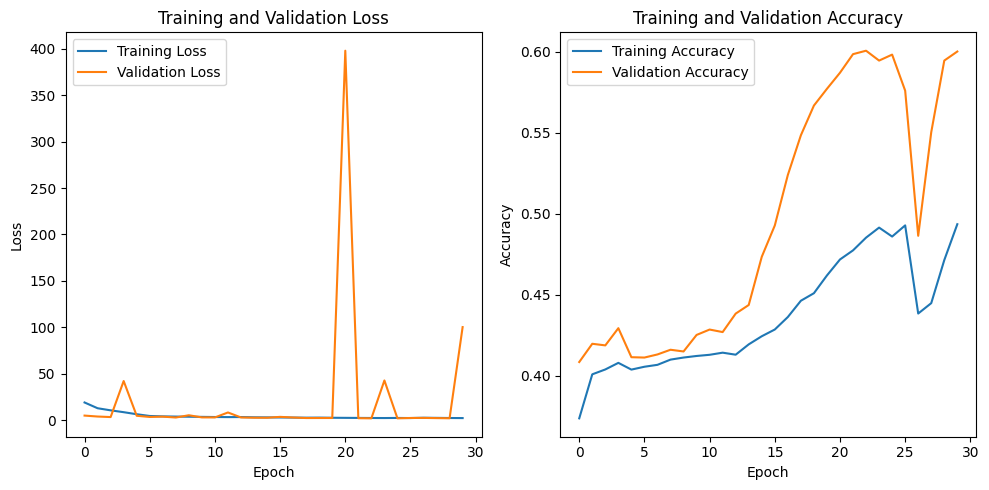

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
import itertools
import numpy as np

# Define the ArithmeticDataset class and helper functions
def get_arithmetic_func(name):
    return {
        '+': lambda x, y, mod: (x, y, (x + y) % mod),
    }[name]

class Vocab:
    def __init__(self, tokens):
        self.stoi = {t: idx for idx, t in enumerate(sorted(tokens))}
        self.itos = {idx: t for idx, t in enumerate(sorted(tokens))}

    def encode(self, obj):
        return torch.tensor([self.stoi[str(s)] for s in obj])

    def decode(self, obj):
        return ' '.join([self.itos[i.item()] for i in obj])

class ArithmeticDataset(Dataset):
    def __init__(self, operator, mod=97):
        self.data, tokens = self.generate_data(operator, mod)
        self.vocab = Vocab(tokens)

    def __getitem__(self, index):
        return self.vocab.encode(self.data[index])

    def __len__(self):
        return len(self.data)

    def decode(self, item):
        return self.vocab.decode(item)

    @staticmethod
    def generate_data(operator, mod):
        function = get_arithmetic_func(operator)
        result = []
        tokens = {'<sos>', '=', str(operator)}
        tuples = itertools.product(range(mod), repeat=2)

        for x, y in tuples:
            x, y, res = function(x, y, mod)
            result.append(['<sos>', x, operator, y, '=', res])
            tokens.update({str(x), str(y), str(res)})

        return result, tokens

# Define the RNN model with Batch Normalization and Dropout
class ArithmeticRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(ArithmeticRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.rnn1 = nn.RNN(hidden_size, hidden_size, batch_first=True, nonlinearity='relu')
        self.rnn2 = nn.RNN(hidden_size, hidden_size, batch_first=True, nonlinearity='relu')
        self.batch_norm1 = nn.BatchNorm1d(hidden_size)
        self.batch_norm2 = nn.BatchNorm1d(hidden_size)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden):
        embedded = self.embedding(x)
        output, hidden = self.rnn1(embedded, hidden)
        output = self.batch_norm1(output.transpose(1, 2)).transpose(1, 2)
        output = self.dropout(output)
        output, hidden = self.rnn2(output, hidden)
        output = self.batch_norm2(output.transpose(1, 2)).transpose(1, 2)
        output = self.dropout(output)
        output = self.fc(output)
        return output, hidden

    def init_hidden(self, batch_size):
        return torch.zeros(1, batch_size, self.hidden_size)

# Hyperparameters
hidden_size = 128
num_epochs = 30
batch_size = 32
learning_rate = 0.001

# Prepare the dataset and dataloader
operator = '+'
mod = 97
dataset = ArithmeticDataset(operator, mod)
vocab_size = len(dataset.vocab.stoi)
output_size = vocab_size  # output size is the same as the number of tokens

# Split dataset into training and testing sets
train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize the model with custom initialization
def init_model(model, alpha):
    with torch.no_grad():
        for name, param in model.named_parameters():
            if 'weight' in name:
                param.data *= alpha

# Compute the weight norm of the model
def compute_weight_norm(model):
    total_norm = 0.0
    for name, param in model.named_parameters():
        if 'weight' in name:
            param_norm = torch.norm(param)
            total_norm += param_norm ** 2
    total_norm = total_norm.sqrt().item()
    return total_norm

# Initialize the model, loss function, and optimizer
model = ArithmeticRNN(vocab_size, hidden_size, output_size)
init_model(model, alpha=5.0)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Track training and validation loss and accuracy
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Function to calculate accuracy
def calculate_accuracy(outputs, targets):
    _, predicted = torch.max(outputs, 2)  # Use dimension 2 because outputs are (batch_size, sequence_length, vocab_size)
    correct = (predicted == targets).sum().item()
    total = targets.numel()
    return correct / total

# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for batch in train_loader:
        batch = batch.long()  # ensure the batch is of type long
        inputs, targets = batch[:, :-1], batch[:, 1:]

        optimizer.zero_grad()
        hidden = model.init_hidden(batch.size(0))

        outputs, hidden = model(inputs, hidden)
        outputs = outputs.view(-1, output_size)
        targets = targets.reshape(-1)

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_correct += (outputs.argmax(1) == targets).sum().item()
        train_total += targets.size(0)

    train_loss /= len(train_loader)
    train_accuracy = train_correct / train_total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for batch in test_loader:
            batch = batch.long()
            inputs, targets = batch[:, :-1], batch[:, 1:]
            hidden = model.init_hidden(batch.size(0))
            outputs, hidden = model(inputs, hidden)
            outputs = outputs.view(-1, output_size)
            targets = targets.reshape(-1)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
            val_correct += (outputs.argmax(1) == targets).sum().item()
            val_total += targets.size(0)

    val_loss /= len(test_loader)
    val_accuracy = val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

# Plotting the training and validation loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


Epoch [1/5000], Train Loss: 21.0817, Train Accuracy: 0.3391, Validation Loss: 4.8431, Validation Accuracy:  0.4169, Weight Norm: 560.0125
Epoch [2/5000], Train Loss: 14.0799, Train Accuracy: 0.3982, Validation Loss: 32.2521, Validation Accuracy:  0.4102, Weight Norm: 560.0587
Epoch [3/5000], Train Loss: 11.5815, Train Accuracy: 0.4009, Validation Loss: 13.4083, Validation Accuracy:  0.4104, Weight Norm: 560.1248
Epoch [4/5000], Train Loss: 8.1938, Train Accuracy: 0.3918, Validation Loss: 4.9012, Validation Accuracy:  0.4149, Weight Norm: 560.1880
Epoch [5/5000], Train Loss: 5.5415, Train Accuracy: 0.3963, Validation Loss: 3.4695, Validation Accuracy:  0.4108, Weight Norm: 560.1870
Epoch [6/5000], Train Loss: 5.2250, Train Accuracy: 0.4023, Validation Loss: 3.6852, Validation Accuracy:  0.4102, Weight Norm: 560.2083
Epoch [7/5000], Train Loss: 6.9584, Train Accuracy: 0.4030, Validation Loss: 4.9759, Validation Accuracy:  0.4031, Weight Norm: 560.2433
Epoch [8/5000], Train Loss: 4.7220, 

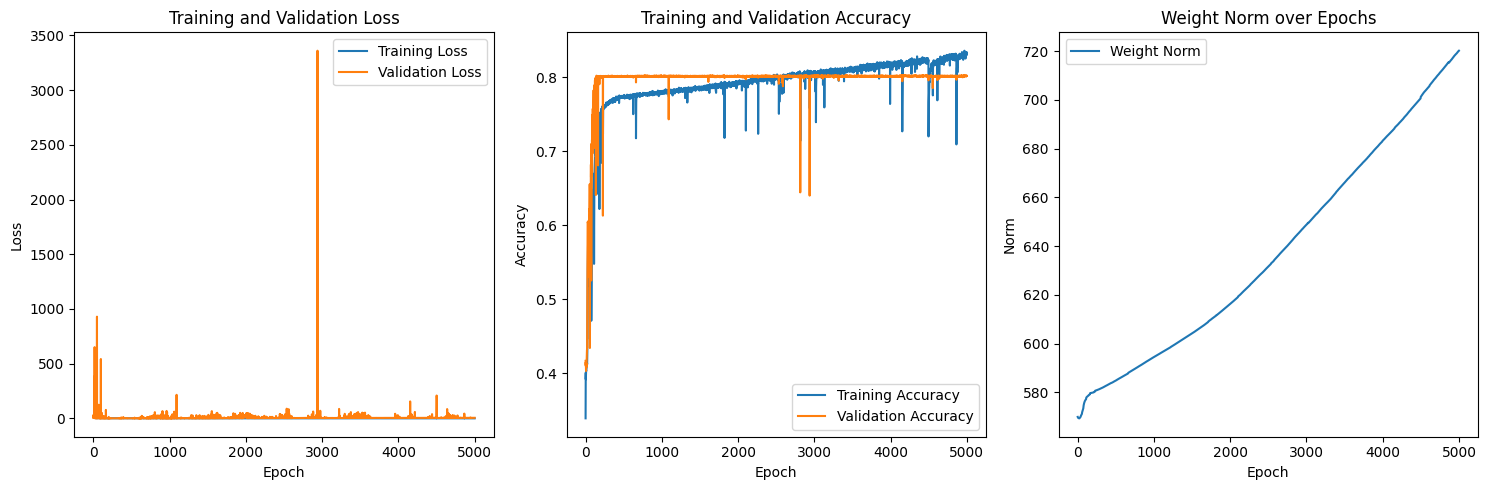

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
import itertools

# Define the ArithmeticDataset class and helper functions
def get_arithmetic_func(name):
    return {
        '+': lambda x, y, mod: (x, y, (x + y) % mod),
    }[name]

class Vocab:
    def __init__(self, tokens):
        self.stoi = {t: idx for idx, t in enumerate(sorted(tokens))}
        self.itos = {idx: t for idx, t in enumerate(sorted(tokens))}

    def encode(self, obj):
        return torch.tensor([self.stoi[str(s)] for s in obj])

    def decode(self, obj):
        return ' '.join([self.itos[i.item()] for i in obj])

class ArithmeticDataset(Dataset):
    def __init__(self, operator, mod=97):
        self.data, tokens = self.generate_data(operator, mod)
        self.vocab = Vocab(tokens)

    def __getitem__(self, index):
        return self.vocab.encode(self.data[index])

    def __len__(self):
        return len(self.data)

    def decode(self, item):
        return self.vocab.decode(item)

    @staticmethod
    def generate_data(operator, mod):
        function = get_arithmetic_func(operator)
        result = []
        tokens = {'<sos>', '=', str(operator)}
        tuples = itertools.product(range(mod), repeat=2)

        for x, y in tuples:
            x, y, res = function(x, y, mod)
            result.append(['<sos>', x, operator, y, '=', res])
            tokens.update({str(x), str(y), str(res)})

        return result, tokens

# Define the RNN model with Batch Normalization and Dropout
class ArithmeticRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(ArithmeticRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.rnn1 = nn.RNN(hidden_size, hidden_size, batch_first=True, nonlinearity='relu')
        self.rnn2 = nn.RNN(hidden_size, hidden_size, batch_first=True, nonlinearity='relu')
        self.batch_norm1 = nn.BatchNorm1d(hidden_size)
        self.batch_norm2 = nn.BatchNorm1d(hidden_size)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden):
        embedded = self.embedding(x)
        output, hidden = self.rnn1(embedded, hidden)
        output = self.batch_norm1(output.transpose(1, 2)).transpose(1, 2)
        output = self.dropout(output)
        output, hidden = self.rnn2(output, hidden)
        output = self.batch_norm2(output.transpose(1, 2)).transpose(1, 2)
        output = self.dropout(output)
        output = self.fc(output)
        return output, hidden

    def init_hidden(self, batch_size):
        return torch.zeros(1, batch_size, self.hidden_size)

# Hyperparameters
hidden_size = 128
num_epochs = 5000
batch_size = 32
learning_rate = 0.001

# Prepare the dataset and dataloader
operator = '+'
mod = 97
dataset = ArithmeticDataset(operator, mod)
vocab_size = len(dataset.vocab.stoi)
output_size = vocab_size  # output size is the same as the number of tokens

# Split dataset into training and testing sets
train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize the model with custom initialization
def init_model(model, alpha):
    with torch.no_grad():
        for name, param in model.named_parameters():
            if 'weight' in name:
                param.data *= alpha

# Initialize the model, loss function, and optimizer
model = ArithmeticRNN(vocab_size, hidden_size, output_size)
init_model(model, alpha=5.0)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Track training and validation loss and accuracy
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
weight_norms = []  # List to store weight norms

# Function to calculate accuracy
def calculate_accuracy(outputs, targets):
    _, predicted = torch.max(outputs, 2)  # Use dimension 2 because outputs are (batch_size, sequence_length, vocab_size)
    correct = (predicted == targets).sum().item()
    total = targets.numel()
    return correct / total

# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for batch in train_loader:
        batch = batch.long()  # ensure the batch is of type long
        inputs, targets = batch[:, :-1], batch[:, 1:]

        optimizer.zero_grad()
        hidden = model.init_hidden(batch.size(0))

        outputs, hidden = model(inputs, hidden)
        outputs = outputs.view(-1, output_size)
        targets = targets.reshape(-1)

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_correct += (outputs.argmax(1) == targets).sum().item()
        train_total += targets.size(0)

    train_loss /= len(train_loader)
    train_accuracy = train_correct / train_total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Compute and store the weight norm
    with torch.no_grad():
        weight_norm = torch.norm(torch.cat([param.view(-1) for param in model.parameters()]), p=2)
        weight_norms.append(weight_norm.item())

    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for batch in test_loader:
            batch = batch.long()
            inputs, targets = batch[:, :-1], batch[:, 1:]
            hidden = model.init_hidden(batch.size(0))
            outputs, hidden = model(inputs, hidden)
            outputs = outputs.view(-1, output_size)
            targets = targets.reshape(-1)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
            val_correct += (outputs.argmax(1) == targets).sum().item()
            val_total += targets.size(0)

    val_loss /= len(test_loader)
    val_accuracy = val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy:  {val_accuracy:.4f}, Weight Norm: {torch.norm(next(model.parameters())):.4f}')



# Plotting the training and validation loss
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plotting the training and validation accuracy
plt.subplot(1, 3, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plotting the weight norm
plt.subplot(1, 3, 3)
plt.plot(weight_norms, label='Weight Norm')
plt.xlabel('Epoch')
plt.ylabel('Norm')
plt.title('Weight Norm over Epochs')
plt.legend()

plt.tight_layout()
plt.show()